In [15]:
# data, system tools
import pandas as pd
import numpy as np
import os
import glob
import itertools

# multiprocessing
import multiprocessing as mp
from functools import partial

# stats
from statsmodels.stats import outliers_influence
import statsmodels.stats.multitest as multi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import scipy.stats
from scipy.stats import truncnorm

# Meshes
from skimage import measure
import nibabel as nib
from copy import deepcopy
import re
import numpy as np

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import LightSource
%matplotlib inline

# colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Writing, loading

In [16]:
def write_obj(fn, verts, faces, normals):
    faces += 1  # 1-based
    with open(fn, 'w') as f:
        for item in verts:
            f.write("v {0} {1} {2}\n".format(item[0],item[1],item[2]))

        for item in normals:
            f.write("vn {0} {1} {2}\n".format(item[0],item[1],item[2]))

        for item in faces:
            f.write("f {0}//{0} {1}//{1} {2}//{2}\n".format(item[0],item[1],item[2]))  

        f.close()

def read_obj(fn):
    import re
    faces_regex = re.compile('f (?P<a>\d+)//(?P<b>\d+) (?P<c>\d+)//(?P<d>\d+) (?P<e>\d+)//(?P<f>\d+)\n')
    faces = []
    normals = []
    verts = []
    with open(fn, 'r') as f:
        obj_file = f.readlines()
        for line in obj_file:
            if line[0:2] == 'vn':
                normals.append(np.array([float(x) for x in line.split(' ')[1:]]))
            elif line[0] == 'v':
                verts.append(np.array([float(x) for x in line.split(' ')[1:4]]))
            elif line[0] == 'f':
                if '//' in line:
                    gd = faces_regex.match(line)
                    faces.append(np.array([int(gd['a'])-1, int(gd['c'])-1, int(gd['e'])-1]))
                else:
                    faces.append(np.array([float(x) for x in line.split(' ')[1:]])-1)
                
    verts = np.array(verts)
    normals = np.array(normals)
    faces = np.array(faces)
    return verts, faces, normals

## Generate meshes

In [17]:
labels_17structures = ['STR-L','STR-R','STN-L','STN-R','SN-L','SN-R',\
                       'RN-L','RN-R','GPi-L','GPi-R','GPe-L','GPe-R',\
                       'THA-L','THA-R','LV-L','LV-R','3V-3','4V-4','AMG-L','AMG-R',\
                       'ic-L','ic-R','VTA-L','VTA-R','fx-lr','PAG-L','PAG-R',\
                       'PPN-L','PPN-R','CL-L','CL-R']

##### 1. Generate meshes per decade

In [6]:
decade = '18to30'

for decade in ['18to30', '71to80']: #, '71to80']:
    all_meshes_data = {}
    bestlabels_data = nib.load(f'/home/pilou/Projects/Ahead-Database/Automated-Parcellation/atlas_maps/qmri2fcm/ahead-qmri2fcm_avg-bestlabel_decade-{decade}.nii.gz').get_fdata()

    for i, roi_name in enumerate(labels_17structures):
        roi_name, hemisphere = roi_name.split('-')

        print(f'{roi_name}... ', end='')

        # data
        raw_data = bestlabels_data.copy()
    #    this_map = bestlabels_data.copy()
        raw_data[raw_data!=(i+1)] = 0
        raw_data[raw_data>0] = 1

        marchCubeSpace = 1.0 / 50.0
        verts, faces, normals, values = measure.marching_cubes(raw_data, 0.5, spacing=(marchCubeSpace, marchCubeSpace, marchCubeSpace))
        all_meshes_data[roi_name + '-' + hemisphere] = {'verts': verts, 'faces': faces, 'normals': normals, 'values': values}

        save_fn = f'./objs/decade-{decade}/bestlabel/{roi_name}-{hemisphere}.obj'
        if not os.path.exists(os.path.dirname(save_fn)):
            os.makedirs(os.path.dirname(save_fn))
        write_obj(save_fn, verts, faces, normals)

STR... STR... STN... STN... SN... SN... RN... RN... GPi... GPi... GPe... GPe... THA... THA... LV... LV... 3V... 4V... AMG... AMG... ic... ic... VTA... VTA... fx... PAG... PAG... PPN... PPN... CL... CL... 

##### 2. Smooth

In [7]:
import pymeshlab
for decade in ['71to80']:
    for fn in sorted(glob.glob(f'./objs/decade-{decade}/bestlabel/*.obj')):
        print(fn, end='..')
        ms = pymeshlab.MeshSet()
        ms.load_new_mesh(fn)
        ms.laplacian_smooth()
        try:
            ms.re_orient_all_faces_coherentely()
        except:
            print('Reorient didnt work')
        ms.invert_faces_orientation()
        save_fn = fn.replace('bestlabel', 'bestlabel_smoothed')
        if not os.path.exists(os.path.dirname(save_fn)):
            os.makedirs(os.path.dirname(save_fn))
        ms.save_current_mesh(fn.replace('bestlabel', 'bestlabel_smoothed'))

./objs/decade-71to80/bestlabel/3V-3.obj.../objs/decade-71to80/bestlabel/4V-4.obj.../objs/decade-71to80/bestlabel/AMG-L.obj.../objs/decade-71to80/bestlabel/AMG-R.obj.../objs/decade-71to80/bestlabel/CL-L.obj.../objs/decade-71to80/bestlabel/CL-R.obj.../objs/decade-71to80/bestlabel/GPe-L.obj.../objs/decade-71to80/bestlabel/GPe-R.obj.../objs/decade-71to80/bestlabel/GPi-L.obj.../objs/decade-71to80/bestlabel/GPi-R.obj.../objs/decade-71to80/bestlabel/LV-L.obj.../objs/decade-71to80/bestlabel/LV-R.obj.../objs/decade-71to80/bestlabel/PAG-L.obj.../objs/decade-71to80/bestlabel/PAG-R.obj.../objs/decade-71to80/bestlabel/PPN-L.obj.../objs/decade-71to80/bestlabel/PPN-R.obj.../objs/decade-71to80/bestlabel/RN-L.obj.../objs/decade-71to80/bestlabel/RN-R.obj.../objs/decade-71to80/bestlabel/SN-L.obj.../objs/decade-71to80/bestlabel/SN-R.obj.../objs/decade-71to80/bestlabel/STN-L.obj.../objs/decade-71to80/bestlabel/STN-R.obj.../objs/decade-71to80/bestlabel/STR-L.obj.../objs/decade-71to80/bestlabel/STR-R.obj.../

##### 3. Load meshes

In [18]:
structs = {}

for decade in ['18to30', '71to80']:
    structs[decade] = {}
    mesh_obj_dir = f'./objs/decade-{decade}/bestlabel_smoothed'
    objs = sorted(glob.glob(os.path.join(mesh_obj_dir, '*.obj')))
    for obj in objs:
        verts, faces, normals = read_obj(obj)
        name = os.path.basename(obj).split('.')[0].upper()
        name = name.replace('GPE', 'GPe').replace('GPI', 'GPi').replace('IC', 'ic').replace('FX-LR', 'fx').replace('VENT-3', '3V').replace('VENT-4', '4V').replace('VENT', 'LV')
        structs[decade][name] = {'verts': verts, 'faces': faces, 'normals': normals}

# Load data, age models, total change table

In [19]:
model_dir = 'app/subcortex-app/data/winning_models/'
qmri_models = models = pd.read_pickle(os.path.join(model_dir, 'qmri_age_models.pkl'))
location_models = pd.read_pickle(os.path.join(model_dir, 'location_models_acrosshemispheres.pkl'))
location_models = location_models.rename(columns={'metric': 'qMRI'})   # for compatibility
models = pd.concat([qmri_models, location_models])

def get_location_shift(result, age, sex=0.5):
    location = result.predict(pd.DataFrame({'Age': age, 'Age2': age**2, 'sex': 0.5}, index=[0])).iloc[0]
    int_loc = result.predict(pd.DataFrame({'Age': 19, 'Age2': 19**2, 'sex': 0.5}, index=[0])).iloc[0]
    return location-int_loc

def get_prediction(result, age, sex=0.5):
    return result.predict(pd.DataFrame({'Age': age, 'Age2': age**2, 'sex': 0.5}, index=[0])).iloc[0]


final_table_absolute = pd.read_pickle('../data/interim_data/summary_table_qmri_absolute.pkl')
final_table_relative = pd.read_pickle('../data/interim_data/summary_table_qmri_proportional.pkl')


df = pd.read_pickle(os.path.join(model_dir, 'qMRI_data_collapsed.pkl'))
df = df.loc[df['high_cook']==False]
df['qMRI'] = df['Intensity']
df['Sex'] = df['sex'].map({0: 'Female', 1: 'Male'})
df = df.loc[df.Intensity != 'qpd']
## Remove Cortex, Cerebellum, save
df = df.loc[~df.ROI.isin(['Cerebellum', 'Cortex'])]
df = df[['Segmentation', 'ROI', 'Intensity', 'Statistic', 'Sex', 'Age',  'Value']]

# Prediction dfs
pred_dfM = pd.DataFrame({'Age': np.arange(19, 81),
                         'Age2': np.arange(19, 81)**2,
                         'sex': 1})
pred_dfF = pd.DataFrame({'Age': np.arange(19, 81),
                         'Age2': np.arange(19, 81)**2,
                         'sex': 0})

In [20]:
def load_mpl_meshes(qMRI, structs, centralize=False):
    all_mpl_meshes = []
    
    ## Set vmax
    if qMRI == 'iron':
        vmax = 30
    else:
        vmax = 20
    vmin = 0

    # First run: just get all random intensities, required for normalizing
    all_intensities = np.array([])
    all_ranges = []
    for i, (roi_name, mesh_data) in enumerate(structs['18to30'].items()):
#         print(f'{roi_name}... ', end='')

        if not roi_name == 'fx':
            roi_name, hemisphere = roi_name.split('-')
        else:
            roi_name = 'fx'
            hemisphere = 'lr'
        verts = mesh_data['verts']
        faces = mesh_data['faces']

        ## 
        for age in [19,75]:
            median_intensity = get_prediction(models.loc[(models.qMRI == qMRI) & (models.ROI == roi_name) & (models.Statistic == 'median'), 'result'].iloc[0], age=age)
            iqr_intensity = get_prediction(models.loc[(models.qMRI == qMRI) & (models.ROI == roi_name) & (models.Statistic == 'iqr'), 'result'].iloc[0], age=age)

            random_intensities = truncnorm.rvs(0, 35, loc=median_intensity, scale=iqr_intensity*1.349425*0.9, size=faces.shape[0])
            all_intensities = np.concatenate([all_intensities, random_intensities])
    
        # verts
        all_ranges.append([verts.min(0), verts.max(0)])
    
    # Find ranges for global center of mass
    xyz_min = np.array(all_ranges).min(0)[0]
    xyz_max = np.array(all_ranges).max(0)[1]
    com = xyz_min+(xyz_max-xyz_min)/2
    
    # Color normalizer
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)

    # Now actually create meshes
    for roi_name_orig in structs['18to30'].keys():
        print(f'{roi_name_orig}... ', end='')

        if not roi_name_orig == 'fx':
            roi_name, hemisphere = roi_name_orig.split('-')
        else:
            roi_name = 'fx'
            hemisphere = 'lr'
        
        # get center of mass of young
        verts = structs['18to30'][roi_name_orig]['verts'].copy()
        xyz_min = verts.min(0)#[0]
        xyz_max = verts.max(0)#[1]
        
        # get shifted ranges - this is the range to plot for young participants
        if centralize:
            xyz_min = (verts-com).min(0)
            xyz_max = (verts-com).max(0)

        for decade in ['18to30', '71to80']:
            verts = structs[decade][roi_name_orig]['verts'].copy()
            faces = structs[decade][roi_name_orig]['faces']
            normals = structs[decade][roi_name_orig]['normals']

            # centralize
            if centralize:
                verts -= com
            
            # Define lightsource
            if hemisphere == 'l':
                azdeg = 0
            else:
                azdeg = 180  # flip light source for right hemisphere
            ls = LightSource(azdeg=azdeg, altdeg=0)
            
            # First change - normals are per vertex, so I made it per face.
            normalsarray = np.array([np.array((np.sum(normals[face[:], 0]/3), np.sum(normals[face[:], 1]/3), 
                                               np.sum(normals[face[:], 2]/3))/np.sqrt(np.sum(normals[face[:], 0]/3)**2 + np.sum(normals[face[:], 1]/3)**2 + np.sum(normals[face[:], 2]/3)**2)) for face in faces])

            # Next this is more asthetic, but it prevents the shadows of the image being too dark. (linear interpolation to correct)
            min_ = np.min(ls.shade_normals(normalsarray, fraction=1.0)) # min shade value
            max_ = np.max(ls.shade_normals(normalsarray, fraction=1.0)) # max shade value
            diff = max_-min_
            newMin = 0.3  # better visibility
            newMax = 0.95  # better visibility
            newdiff = newMax-newMin
            
            #  Create Ploy3D and set up a light source
            mesh = Poly3DCollection(verts[faces], alpha=1)

            # Get color
            if decade == '18to30':
                age = 23
            else:
                age = 73
            median_intensity = get_prediction(models.loc[(models.qMRI == qMRI) & (models.ROI == roi_name) & (models.Statistic == 'median'), 'result'].iloc[0], age=age)
            iqr_intensity = get_prediction(models.loc[(models.qMRI == qMRI) & (models.ROI == roi_name) & (models.Statistic == 'iqr'), 'result'].iloc[0], age=age)

            # Color per face; generate some random intensities with (approx) correct median & IQR of observed intensities
            random_intensities = truncnorm.rvs(0, 35, loc=median_intensity, scale=iqr_intensity*1.349425*0.9, size=faces.shape[0])
            colourRGB = mapper.to_rgba(random_intensities)

            # The correct shading for shadows are now applied. Use the face normals and light orientation to generate a shading value and apply to the RGB colors for each face.
            rgbNew = colourRGB*(newMin + newdiff*((ls.shade_normals(normalsarray, fraction=1.0)[:,np.newaxis]-min_)/diff))

#             # Using a constant color, put in desired RGB values here.
#             colourRGB = np.array(matplotlib.colors.to_rgba(settings[roi_name]['color']))

#             # The correct shading for shadows are now applied. Use the face normals and light orientation to generate a shading value and apply to the RGB colors for each face.
#             rgbNew = colourRGB*(newMin + newdiff*((ls.shade_normals(normalsarray, fraction=1.0)[:,np.newaxis]-min_)/diff))

#             # Apply color to face
            if decade == '18to30':
                young_mesh = deepcopy(mesh)
                young_mesh.set_facecolor(rgbNew)
            else:
                old_mesh = deepcopy(mesh)
                old_mesh.set_facecolor(rgbNew)
        
        all_mpl_meshes.append({'mesh': young_mesh,  # mesh at 25 yo
                               'old_mesh': old_mesh,  # mesh at 75 yo
                               'ranges': [xyz_min, xyz_max],
                               'name': roi_name, 
                               'hemisphere': hemisphere,
                               'color': 'grey'})

#         ## loop over ages to generate two meshes with different face colors
#         for age in [25,75]:
#             median_intensity = get_prediction(models.loc[(models.qMRI == qMRI) & (models.ROI == roi_name) & (models.Statistic == 'median'), 'result'].iloc[0], age=age)
#             iqr_intensity = get_prediction(models.loc[(models.qMRI == qMRI) & (models.ROI == roi_name) & (models.Statistic == 'iqr'), 'result'].iloc[0], age=age)

#             # Color per face; generate some random intensities with (approx) correct median & IQR of observed intensities
#             random_intensities = truncnorm.rvs(0, 35, loc=median_intensity, scale=iqr_intensity*1.349425*0.9, size=faces.shape[0])
#             colourRGB = mapper.to_rgba(random_intensities)

#             # The correct shading for shadows are now applied. Use the face normals and light orientation to generate a shading value and apply to the RGB colors for each face.
#             rgbNew = colourRGB*(newMin + newdiff*((ls.shade_normals(normalsarray, fraction=1.0)[:,np.newaxis]-min_)/diff))

#             # Apply color to face
#             if age == 19:
#                 mesh.set_facecolor(rgbNew)
#             elif age == 75:
#                 old_mesh = deepcopy(mesh)
#                 old_mesh.set_facecolor(rgbNew)

#         all_mpl_meshes.append({'mesh':deepcopy(mesh), 'old_mesh':deepcopy(old_mesh), 'ranges': [verts.min(0), verts.max(0)], 'name': roi_name, 'hemisphere': hemisphere})
    return all_mpl_meshes, norm



#     for roi_name_orig in structs['18to30'].keys():
#         print(f'{roi_name_orig}... ', end='')
        
#         if not roi_name_orig == 'fx':
#             roi_name, hemisphere = roi_name_orig.split('-')
#         else:
#             roi_name = 'fx'
#             hemisphere = 'lr'
        
#         # get center of mass of young
#         verts = structs['18to30'][roi_name_orig]['verts'].copy()
#         xyz_min = verts.min(0)#[0]
#         xyz_max = verts.max(0)#[1]
#         com = xyz_min+(xyz_max-xyz_min)/2
        
#         # get shifted ranges - this is the range to plot for young participants
#         if centralize:
#             xyz_min = (verts-com).min(0)
#             xyz_max = (verts-com).max(0)
        
#         for decade in ['18to30', '71to80']:
#             verts = structs[decade][roi_name_orig]['verts'].copy()
#             faces = structs[decade][roi_name_orig]['faces']
#             normals = structs[decade][roi_name_orig]['normals']
        
# #         # centralize
#             if centralize:
#                 verts -= com
#             # Define lightsource
#             ls = LightSource(azdeg=azdeg, altdeg=altdeg)

#             # First change - normals are per vertex, so I made it per face.
#             normalsarray = np.array([np.array((np.sum(normals[face[:], 0]/3), np.sum(normals[face[:], 1]/3), 
#                                                np.sum(normals[face[:], 2]/3))/np.sqrt(np.sum(normals[face[:], 0]/3)**2 + np.sum(normals[face[:], 1]/3)**2 + np.sum(normals[face[:], 2]/3)**2)) for face in faces])

#             # Next this is more asthetic, but it prevents the shadows of the image being too dark. (linear interpolation to correct)
#             min_ = np.min(ls.shade_normals(normalsarray, fraction=1.0)) # min shade value
#             max_ = np.max(ls.shade_normals(normalsarray, fraction=1.0)) # max shade value
#             diff = max_-min_
#             newMin = 0.3
#             newMax = 0.95
#             newdiff = newMax-newMin

#             # Create Ploy3D and set up a light source
#             mesh = Poly3DCollection(verts[faces])

#             # Using a constant color, put in desired RGB values here.
#             colourRGB = np.array(matplotlib.colors.to_rgba(settings[roi_name]['color']))

#             # The correct shading for shadows are now applied. Use the face normals and light orientation to generate a shading value and apply to the RGB colors for each face.
#             rgbNew = colourRGB*(newMin + newdiff*((ls.shade_normals(normalsarray, fraction=1.0)[:,np.newaxis]-min_)/diff))

#             # Apply color to face
#             if decade == '18to30':
#                 young_mesh = deepcopy(mesh)
#                 young_mesh.set_facecolor(rgbNew)
# #                 young_mesh.set_alpha(alphas[0])
#             elif decade == '71to80':
                
#                 if centralize:
#                     # determine plotting (x,y,z)limits of the elderly: We want the _ranges_ to be the same as the young, but centered on the COM of the elderly mesh
#                     xyz_min_old = verts.min(0)#[0]
#                     xyz_max_old = verts.max(0)#[1]
#                     com = xyz_min_old+(xyz_max_old-xyz_min_old)/2 # should be approximately 0,0,0

#                     ranges_old = [com+xyz_min, com+xyz_max]
#                 else:
#                     ranges_old = [xyz_min, xyz_max]
            
#                 old_mesh = deepcopy(mesh)
#                 old_mesh.set_facecolor(rgbNew)
# #                 old_mesh.set_alpha(alphas[1])

#         all_mpl_meshes.append({'mesh':deepcopy(young_mesh),  # mesh at 19 yo
#                                'old_mesh':deepcopy(old_mesh),  # mesh at 75 yo
#                                'ranges': [xyz_min, xyz_max], #[verts.min(0), verts.max(0)], 
#                                'ranges_old': ranges_old,
#                                'name': roi_name, 
#                                'hemisphere': hemisphere,
# #                                'com': com, # center of mass at 19 yo
# #                                'shifts': [x_shift, y_shift, z_shift], # shift in com between 19-75 yo
#                                'color': 'grey'})
    
# #        all_mpl_meshes.append({'mesh':deepcopy(mesh), 'old_mesh':deepcopy(old_mesh), 'ranges': [verts.min(0), verts.max(0)], 'name': roi_name, 'hemisphere': hemisphere})
#     return all_mpl_meshes

3V-3... 4V-4... AMG-L... AMG-R... CL-L... CL-R... GPe-L... GPe-R... GPi-L... GPi-R... LV-L... LV-R... PAG-L... PAG-R... PPN-L... PPN-R... RN-L... RN-R... SN-L... SN-R... STN-L... STN-R... STR-L... STR-R... THA-L... THA-R... VTA-L... VTA-R... fx... ic-L... ic-R... 

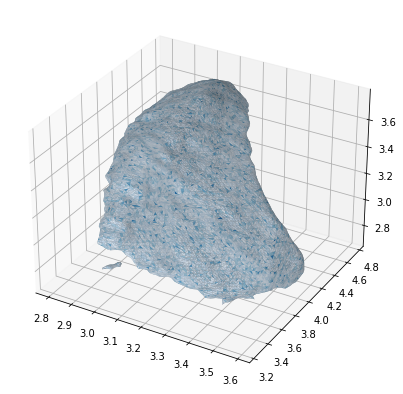

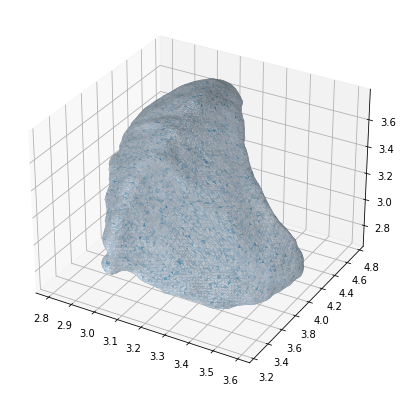

In [11]:
def plot_single_mesh(mesh, ranges):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1,2,1,projection='3d')
    ax.add_collection3d(deepcopy(mesh))
    ax.set_xlim([ranges[0][0],ranges[1][0]])
    ax.set_ylim([ranges[0][1],ranges[1][1]])
    ax.set_zlim([ranges[0][2],ranges[1][2]])
    
def plot_all_meshes(meshes, view_init_az=0, view_init_or=180):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1,1,1,projection='3d')
    
    all_ranges = []
    for mesh_info in meshes:
        mesh = mesh_info['mesh']
        ranges = mesh_info['ranges']
        ax.add_collection3d(deepcopy(mesh))
        all_ranges.append(ranges)

    ax.view_init(view_init_az,view_init_or)
    xyz_min = np.array(all_ranges).min(0)[0]
    xyz_max = np.array(all_ranges).max(0)[1]
    ax.set_xlim([xyz_min[0],xyz_max[0]])
    ax.set_ylim([xyz_min[1],xyz_max[1]])
    ax.set_zlim([xyz_min[2],xyz_max[2]])
    
all_mpl_meshes, norm = load_mpl_meshes('iron', structs)
to_plot = [x for x,i in enumerate(all_mpl_meshes) if i['name']=='ic'][0]
plot_single_mesh(all_mpl_meshes[to_plot]['old_mesh'], all_mpl_meshes[to_plot]['ranges'])
plot_single_mesh(all_mpl_meshes[to_plot]['mesh'], all_mpl_meshes[to_plot]['ranges'])

In [10]:
# plot_all_meshes(all_mpl_meshes)

## Plot!

In [21]:
def plot_timespans_with_meshes(all_mpl_meshes, df, qMRI, total_changes_table, draft=False):
    # Plot a draft? if True, don't plot meshes
    # draft = False

    meshes_df = pd.DataFrame(all_mpl_meshes)
    meshes_to_plot = meshes_df.loc[(~meshes_df['name'].isin(['3V', '4V', 'LV']))&(meshes_df.hemisphere.isin(['L', 'lr']))]
    meshes_to_plot['name_lowercase'] = meshes_to_plot['name'].apply(lambda x: x.lower())
    meshes_to_plot = meshes_to_plot.sort_values('name_lowercase')

    # Plot all, see if young -> old changes can be seen
    xwidth_cm = 30 ## this is way too wide for a4 but does give a nice figure when resized. 16 x 16 cm should fit on A4 (keeping margins in mind)
    fig = plt.figure(figsize=(xwidth_cm/2.54, xwidth_cm/2.54))
    gs = matplotlib.gridspec.GridSpec(4*3, # row for meshes, row for scatters, row empty 
                                      4*3, # two cols for meshes/scatters, one col empty 
                                      figure=fig, left=None, bottom=None, right=None, top=None, wspace=0, hspace=0, 
                                      width_ratios=[1,1,0.1] * 4, 
                                      height_ratios=[1,1,0.1] * 4)

    intensity = qMRI
    scatter_ylim = [df.loc[(df['Intensity'] == intensity),'Value'].min(),df.loc[(df['Intensity'] == intensity),'Value'].max()]
    for i,(idx,row_data) in enumerate(meshes_to_plot.iterrows()):
        col = (i+2)%4 * 3  # two rows per 'subplot', one empty. Shift by two for overall plots
        row = np.floor((i+2)/4).astype(int) * 3 # two columns per 'subplot', one empty

        # Meshes
        for ii, mesh_type in enumerate(['young_left', 'old_right']):
            if ii == 1:
                mesh = row_data['old_mesh']  # old, right
            else:
                mesh = row_data['mesh']     # young, left
            ranges = row_data['ranges']

            ax = fig.add_subplot(gs[row, col+ii], projection='3d')
            if not draft:
                ax.add_collection3d(deepcopy(mesh))
            ax.set_xlim([ranges[0][0], ranges[1][0]])
            ax.set_ylim([ranges[0][1], ranges[1][1]])
            ax.set_zlim([ranges[0][2], ranges[1][2]])
            if not draft:
                ax.axis('off')
            ax.set_box_aspect(aspect=(1,1,1),zoom=1.2)
    #         if ii == 1:
    #             ax.view_init(20, 180)
    #         else:
            ax.view_init(30, 30)
            if ii == 0:
                print('.', end='')
#                 print('{}: ax.azim {}, ax.elev {}'.format(row_data['name'] + '-' + row_data['hemisphere'], ax.azim, ax.elev))
                ax.set_title('23y', loc='left', y=.1, fontdict={'fontsize': 10}, bbox=dict(facecolor='white', alpha=0.75, edgecolor='white', pad=1))
            else:
                ax.set_title('73y', loc='right', y=.1, fontdict={'fontsize': 10}, bbox=dict(facecolor='white', alpha=0.75, edgecolor='white', pad=1))

        ax = fig.add_subplot(gs[slice(row, row+3), slice(col, col+2)])
        roi_name = row_data['name']
        if roi_name in ['fx', 'ic']:
            roi_name = '$\it{' + roi_name + '}$'
        ax.set_title(roi_name, y=.9)
        ax.axis('off')

        # scatterplots
        for ii, statistic in enumerate(['median', 'iqr']):
            ax = fig.add_subplot(gs[row+1,col+ii])
            data_ = df.loc[(df['ROI']==row_data['name']) & (df['Intensity'] == intensity) & (df['Statistic'] == statistic)]
            ax.grid(linestyle='--', color='lightgrey')
            ax.scatter(data_.Age, data_.Value, s=1, color=colors[0])
            ax.set_ylim(scatter_ylim)
            if row/3 < 3:
                ax.set_xticklabels([])
            # model
            result_ = models.loc[(models.ROI == row_data['name']) & (models.qMRI == intensity) & (models.Statistic == statistic), 'result'].iloc[0]
            pred1 = result_.predict(pred_dfM)
            pred2 = result_.predict(pred_dfF)
            if (pred1 == pred2).all():
                ax.plot(np.arange(19,81), pred1, 'k')
            else:
                ax.plot(np.arange(19,81), pred1, 'red')
                ax.plot(np.arange(19,81), pred2, 'green')
            ax.set_yticks([0,10,20])
            if col > 0 or ii == 1:
                ax.set_yticklabels([])
            title_text = ' Med.' if statistic == 'median' else ' IQR'
            if data_.Value.mean() > 10:
                title_y_pos = 0.05
            else:
                title_y_pos = 0.8
            
            # change to percentage
            total_change = total_changes_table.loc[row_data['name'], (qMRI, statistic)]
#             title_text += ': ' + str(total_change.round(2))
            sign = '+' if total_change > 0 else ''
            title_text += ': ' + sign + str((total_change * 100).round(2)) + '%'
            ax.set_title(title_text, y=title_y_pos, loc='left', fontdict={'fontsize': 10})

    # complete subcortex?
    # create new subgridspec
    gs00 = gs[:2,:6].subgridspec(3, 4, wspace=0, hspace=0, width_ratios=[.03, 1, 1, .1], height_ratios=[1, 1, .1])
    #gs01 = gs[1].subgridspec(3, 2)
    for ii, (az, orientation) in enumerate([(0,180), (0,0)]):
    #     ax = fig.add_subplot(gs[:2,(ii*3):(ii*3+2)], projection='3d')
        ax = fig.add_subplot(gs00[:2,ii+1], projection='3d')
        all_ranges = []
        for i,(idx,row_data) in enumerate(meshes_to_plot.iterrows()):
            print('.', end='')
            mesh = row_data['mesh']     # young, left
            all_ranges.append(row_data['ranges'])
            if not draft:
                tmp = ax.add_collection3d(deepcopy(mesh))
            else:
                if i == 0:
                    ax.add_collection3d(deepcopy(mesh))

        ax.view_init(az,orientation)
        ax.set_box_aspect(aspect=(1,1,1),zoom=1.2)
        xyz_min = np.array(all_ranges).min(0)[0]
        xyz_max = np.array(all_ranges).max(0)[1]
    #    print(xyz_min)
    #    print(xyz_max)
        ax.set_xlim([xyz_min[0],xyz_max[0]])
        ax.set_ylim([xyz_min[1],xyz_max[1]])
        ax.set_zlim([xyz_min[2],xyz_max[2]])
        if not draft:
            ax.axis('off')

    # Colorbar
    cbar_ax1 = fig.add_subplot(gs00[1,0])
    cb1 = mpl.colorbar.ColorbarBase(cbar_ax1, cmap=cm.Blues, norm=norm, ticklocation='left')
#    cb1.set_label('{} (ppm)'.format(qMRI.capitalize()))

    fig.text(0.5, 0.1, 'Age', ha='center')
    fig.text(0.08, 0.5, '{} (ppm)'.format(qMRI.capitalize()), va='center', rotation='vertical')
#     fig.text(0.08, 0.5, 'Modeled {} (ppm)'.format(qMRI), va='center', rotation='vertical')

    sns.despine()
    
    return fig

3V-3... 4V-4... AMG-L... AMG-R... CL-L... CL-R... GPe-L... GPe-R... GPi-L... GPi-R... LV-L... LV-R... PAG-L... PAG-R... PPN-L... PPN-R... RN-L... RN-R... SN-L... SN-R... STN-L... STN-R... STR-L... STR-R... THA-L... THA-R... VTA-L... VTA-R... fx... ic-L... ic-R... 

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


..........................................

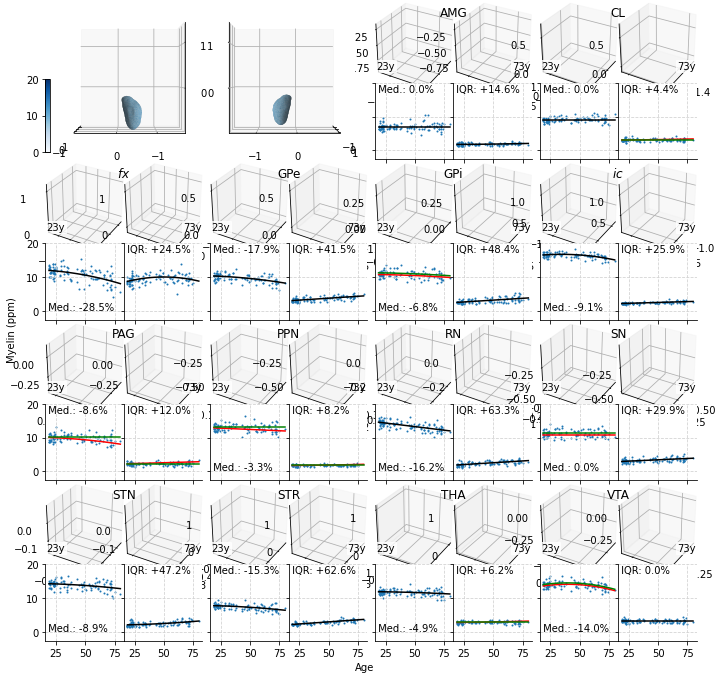

In [22]:
qMRI = 'myelin'
structs_to_plot = deepcopy(structs)
structs_to_plot['18to30'] = {x:y for x,y in structs['18to30'].items() if (x.endswith('L') or x == 'fx') and not x in ['LV-L', '3V-3', '4V-4']} # need to do this here in order to take into account global COM
structs_to_plot['71to80'] = {x:y for x,y in structs['71to80'].items() if (x.endswith('L') or x == 'fx') and not x in ['LV-L', '3V-3', '4V-4']} # need to do this here in order to take into account global COM
all_mpl_meshes, norm = load_mpl_meshes(qMRI, structs, centralize=True)

fig = plot_timespans_with_meshes(all_mpl_meshes, df, qMRI, total_changes_table=final_table_relative, draft=True)

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


..........................................

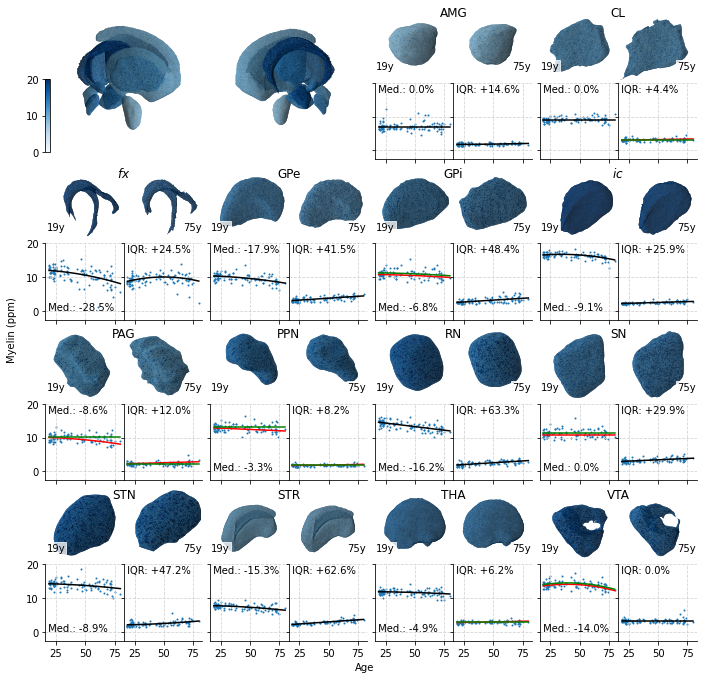

In [34]:
fig = plot_timespans_with_meshes(all_mpl_meshes, df, qMRI, total_changes_table=final_table_relative, draft=False)

AMG-L... CL-L... GPe-L... GPi-L... PAG-L... PPN-L... RN-L... SN-L... STN-L... STR-L... THA-L... VTA-L... fx... ic-L... ..........................................AMG-L... CL-L... GPe-L... GPi-L... PAG-L... PPN-L... RN-L... SN-L... STN-L... STR-L... THA-L... VTA-L... fx... ic-L... ..........................................

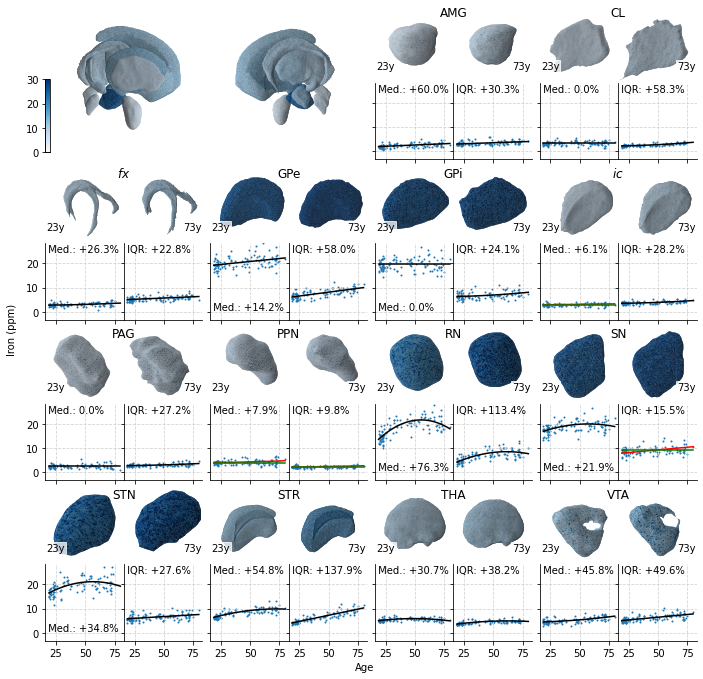

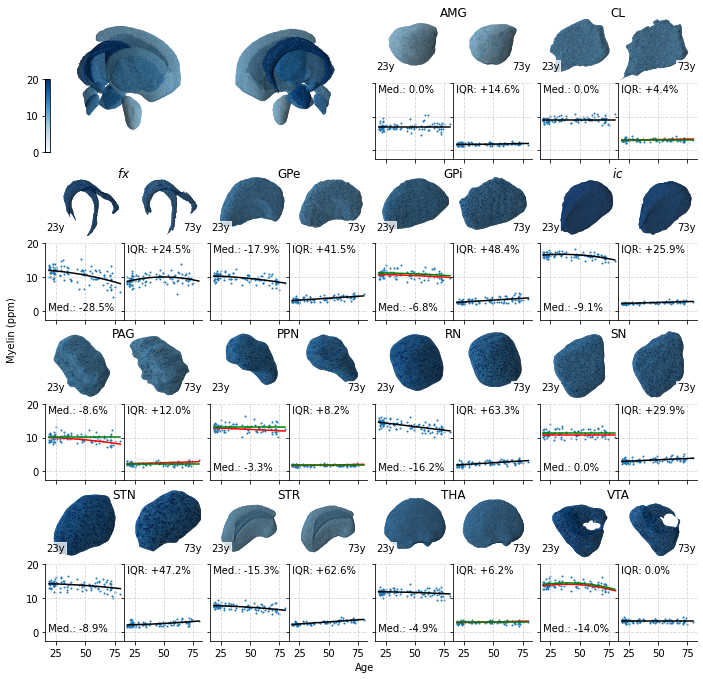

In [23]:
qMRI = 'iron'

for qMRI in ['iron', 'myelin']:
    structs_to_plot = deepcopy(structs)
    structs_to_plot['18to30'] = {x:y for x,y in structs['18to30'].items() if (x.endswith('L') or x == 'fx') and not x in ['LV-L', '3V-3', '4V-4']} # need to do this here in order to take into account global COM
    structs_to_plot['71to80'] = {x:y for x,y in structs['71to80'].items() if (x.endswith('L') or x == 'fx') and not x in ['LV-L', '3V-3', '4V-4']} # need to do this here in order to take into account global COM
    all_mpl_meshes, norm = load_mpl_meshes(qMRI, structs_to_plot, centralize=True)

    fig = plot_timespans_with_meshes(all_mpl_meshes, df, qMRI, total_changes_table=final_table_relative)
#     fig.savefig(f'./{qMRI}_timespan.pdf', bbox_inches='tight')
    fig.savefig(f'../figures/aging_{qMRI}-massp2-newmeshes_r1_2.jpeg', dpi=250, bbox_inches='tight')

In [ ]:
## Ok, now thickness

In [399]:
## Location change

In [11]:
def load_mpl_location_meshes(structs, alphas=[0.5,0.5], azdeg=0, altdeg=0):
    all_mpl_meshes = []
    
    settings = {'AMG': {'color': 'red'},
            'CL': {'color': 'orange'},
            'fx': {'color': 'lightgrey'},
            'GPe': {'color': 'darkblue'},
            'GPi': {'color': 'lightblue'},
            'ic': {'color': 'darkorange'},
            'ICO': {'color': 'darkorange'},
            'PAG': {'color': 'grey'},
            'PPN': {'color': 'blue'},
            'RN': {'color': 'red'},
            'SCO': {'color': 'darkorange'},
            'SN': {'color': 'black'},
            'STN': {'color': 'purple'},
            'STR': {'color': 'lightgreen'},
            'THA': {'color': 'darkgreen'},
            'LV': {'color': 'white'},
            '3V': {'color': 'white'},
            '4V': {'color': 'white'},
            'VTA': {'color': 'forestgreen'},
           }

    # Now create meshes
    for roi_name, mesh_data in structs.items():
        print(f'{roi_name}... ', end='')

        if not roi_name == 'fx':
            roi_name, hemisphere = roi_name.split('-')
        else:
            roi_name = 'fx'
            hemisphere = 'lr'
        verts = mesh_data['verts'].copy()
        faces = mesh_data['faces']
        normals = mesh_data['normals']
        
        # Define lightsource
        ls = LightSource(azdeg=azdeg, altdeg=altdeg)

        # First change - normals are per vertex, so I made it per face.
        normalsarray = np.array([np.array((np.sum(normals[face[:], 0]/3), np.sum(normals[face[:], 1]/3), 
                                           np.sum(normals[face[:], 2]/3))/np.sqrt(np.sum(normals[face[:], 0]/3)**2 + np.sum(normals[face[:], 1]/3)**2 + np.sum(normals[face[:], 2]/3)**2)) for face in faces])

        # Next this is more asthetic, but it prevents the shadows of the image being too dark. (linear interpolation to correct)
        min_ = np.min(ls.shade_normals(normalsarray, fraction=1.0)) # min shade value
        max_ = np.max(ls.shade_normals(normalsarray, fraction=1.0)) # max shade value
        diff = max_-min_
        newMin = 0.3
        newMax = 0.95
        newdiff = newMax-newMin
        
        xyz_min = verts.min(0)
        xyz_max = verts.max(0)
        com = xyz_min+(xyz_max-xyz_min)/2

        ## loop over ages to generate two meshes with different face colors
        for age in [19,75]:
            verts = mesh_data['verts'].copy()  # copy verts, break pointer
            y_shift = get_location_shift(models.loc[(models.qMRI == 'location') & (models.ROI == roi_name) & (models.Statistic == 'Y_mni'), 'result'].iloc[0], age=age)/50*2   # marching cubes had 1/50 scaling based on 0.5mm data, models are in mm
            z_shift = get_location_shift(models.loc[(models.qMRI == 'location') & (models.ROI == roi_name) & (models.Statistic == 'Z_mni'), 'result'].iloc[0], age=age)/50*2
            x_shift = get_location_shift(models.loc[(models.qMRI == 'location') & (models.ROI == roi_name) & (models.Statistic == 'X_mni_abs'), 'result'].iloc[0], age=age)/50*2
#             print('{} {} {}...'.format(x_shift, y_shift, z_shift), end='')

#             if not roi_name == 'fx':
            if hemisphere == 'L':
                verts[:,0] -= x_shift   # nb: x-axis is flipped, so left is positive, right is negative (!) RAS # ToDO: DOUBLE CHECK THIS
            elif hemisphere == 'R':
                verts[:,0] += x_shift
            verts[:,1] += y_shift
            verts[:,2] += z_shift
                
            # Create Ploy3D
#             if age == 19:
#                 alpha = alphas[0]
#             else:
#                 alpha = alphas[1]
            mesh = Poly3DCollection(verts[faces])
            
            # Using a constant color, put in desired RGB values here.
            colourRGB = np.array(matplotlib.colors.to_rgba(settings[roi_name]['color']))

            # The correct shading for shadows are now applied. Use the face normals and light orientation to generate a shading value and apply to the RGB colors for each face.
            rgbNew = colourRGB*(newMin + newdiff*((ls.shade_normals(normalsarray, fraction=1.0)[:,np.newaxis]-min_)/diff))

            # Apply color to face
            if age == 19:
                young_mesh = deepcopy(mesh)
                young_mesh.set_facecolor(rgbNew)
                young_mesh.set_alpha(alphas[0])
            elif age == 75:
                old_mesh = deepcopy(mesh)
                old_mesh.set_facecolor(rgbNew)
                old_mesh.set_alpha(alphas[1])

        all_mpl_meshes.append({'mesh':deepcopy(young_mesh),  # mesh at 19 yo
                               'old_mesh':deepcopy(old_mesh),  # mesh at 75 yo
                               'ranges': [verts.min(0), verts.max(0)], 
                               'name': roi_name, 
                               'hemisphere': hemisphere,
                               'com': com, # center of mass at 19 yo
                               'shifts': [x_shift, y_shift, z_shift], # shift in com between 19-75 yo
                               'color': np.array(matplotlib.colors.to_rgba(settings[roi_name]['color']))})
        
    return all_mpl_meshes, norm

In [39]:
all_mpl_meshes, norm = load_mpl_location_meshes(structs['18to30'], alphas=[1,1])

#plot_all_meshes(all_mpl_meshes)

3V-3... 4V-4... AMG-L... AMG-R... CL-L... CL-R... GPe-L... GPe-R... GPi-L... GPi-R... LV-L... LV-R... PAG-L... PAG-R... PPN-L... PPN-R... RN-L... RN-R... SN-L... SN-R... STN-L... STN-R... STR-L... STR-R... THA-L... THA-R... VTA-L... VTA-R... fx... ic-L... ic-R... 

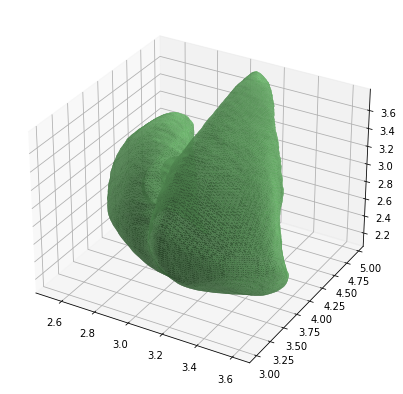

In [640]:
to_plot = [x for x,i in enumerate(all_mpl_meshes) if i['name']=='STR'][0]
plot_single_mesh(all_mpl_meshes[to_plot]['mesh'], all_mpl_meshes[to_plot]['ranges'])

## maybe arrows on transparant meshes?

In [12]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [13]:
idx = 3
mesh, ranges, com, shifts, col = all_mpl_meshes[idx]['mesh'], all_mpl_meshes[idx]['ranges'], all_mpl_meshes[idx]['com'], all_mpl_meshes[idx]['shifts'].copy(), all_mpl_meshes[idx]['color']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1,2,1,projection='3d')
ax.add_collection3d(deepcopy(mesh))
ax.set_xlim([ranges[0][0],ranges[1][0]])
ax.set_ylim([ranges[0][1],ranges[1][1]])
ax.set_zlim([ranges[0][2],ranges[1][2]])
ax.arrow3D(com[0], com[1], com[2],
           shifts[0],shifts[1],shifts[2],
           mutation_scale=15,
           arrowstyle="-|>",
           linestyle='-',
           ec ='black',
           fc=col)

KeyError: 'com'

In [ ]:
def plot_all_meshes_with_arrows(meshes, view_init_az=90, view_init_or=180, alpha=None, linewidth=None, zoom=1.3,
                                fig=None, ax=None, draft=False, mutation_scale_large=5, mutation_scale_small=3,
                                xyz_min=None, xyz_max=None):
    
    if fig is None:
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(1,1,1,projection='3d')
    
    all_ranges = []
    for mesh_info in meshes:
        mesh = mesh_info['mesh']
        ranges = mesh_info['ranges']
        if alpha is not None:
            mesh.set_alpha(alpha)
        
        if not draft:
            ax.add_collection3d(deepcopy(mesh))
        com = mesh_info['com']
        shifts = mesh_info['shifts'].copy() #?? required somehow
        if mesh_info['hemisphere'] == 'L':
            shifts[0] *= -1
            
        movement = np.sqrt(np.sum(np.array(shifts)**2))
        if movement < 0.1:
            mutation_scale = mutation_scale_small
        else:
            mutation_scale = mutation_scale_large
        
#         if mesh_info['name'] != 'fx':
        ax.arrow3D(com[0], com[1], com[2],
                   shifts[0], shifts[1], shifts[2],
                   mutation_scale=mutation_scale,
                   arrowstyle="-|>",
                   linestyle='-',
                   linewidth=linewidth,
                   ec='k',
                   fc='k')

        all_ranges.append(ranges)
    
    ax.set_box_aspect(aspect=(1,1,1),zoom=zoom)
    ax.view_init(view_init_az,view_init_or)
    
    if xyz_min is None:
        xyz_min = np.array(all_ranges).min(0)[0]
        xyz_max = np.array(all_ranges).max(0)[1]
    
    ax.set_xlim([xyz_min[0],xyz_max[0]])
    ax.set_ylim([xyz_min[1],xyz_max[1]])
    ax.set_zlim([xyz_min[2],xyz_max[2]])
    ax.invert_xaxis()  # flip left-right, data is in LAS
    if not draft:
        ax.axis('off')
    return xyz_min, xyz_max
# plot_all_meshes_young_and_old(all_mpl_meshes)

## Combine

In [28]:
settings = {'AMG': {'color': 'red'},
            'CL': {'color': 'orange'},
            'fx': {'color': 'lightgrey'},
            'GPe': {'color': 'darkblue'},
            'GPi': {'color': 'lightblue'},
            'ic': {'color': 'darkorange'},
#             'ICO': {'color': 'darkorange'},
            'PAG': {'color': 'grey'},
            'PPN': {'color': 'blue'},
            'RN': {'color': 'red'},
#             'SCO': {'color': 'darkorange'},
            'SN': {'color': 'black'},
            'STN': {'color': 'purple'},
            'STR': {'color': 'lightgreen'},
            'THA': {'color': 'darkgreen'},
            'LV': {'color': 'white'},
            '3V': {'color': 'white'},
            '4V': {'color': 'white'},
            'VTA': {'color': 'forestgreen'},
           }


3V-3... 4V-4... AMG-L... AMG-R... CL-L... CL-R... GPe-L... GPe-R... GPi-L... GPi-R... LV-L... LV-R... PAG-L... PAG-R... PPN-L... PPN-R... RN-L... RN-R... SN-L... SN-R... STN-L... STN-R... STR-L... STR-R... THA-L... THA-R... VTA-L... VTA-R... fx... ic-L... ic-R... 

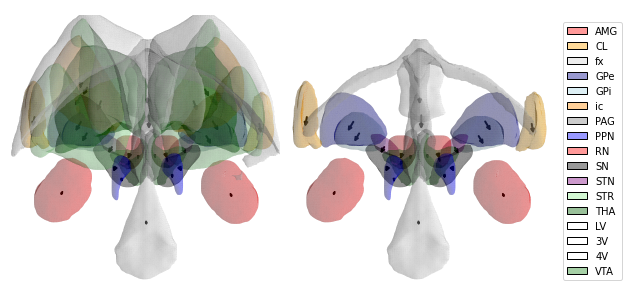

In [52]:
from matplotlib.patches import Patch
draft = False
fig = plt.figure(figsize=(9, 4.5))
gs = matplotlib.gridspec.GridSpec(1, 3, 
                                  figure=fig, left=None, bottom=None, right=None, top=None, 
                                  wspace=0, hspace=0, 
                                  width_ratios=[1,1,.3], 
                                 )

# frontal view
azdeg= 90
if not draft:
    all_mpl_meshes, norm = load_mpl_location_meshes(structs['18to30'], alphas=[1,1], azdeg=azdeg)
ax = fig.add_subplot(gs[0,0], projection='3d')
xyz_min, xyz_max = plot_all_meshes_with_arrows([x for x in all_mpl_meshes if x['name'] in ['AMG', 'CL', 'fx', 'GPi', 'GPe',  'ic', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'STR', 'THA', 'VTA', '3V', '4V', 'LV']
                                                # ['GPi', 'GPe', 'CL', 'PAG', 'SN', 'STN', 'RN', 'AMG', 'VTA', 'STR',  '3V', '4V', 'fx', 'LV']
                                                ], 0, azdeg, alpha=0.25, linewidth=2,
                                                fig=fig, ax=ax, draft=draft, mutation_scale_large=7, mutation_scale_small=2, zoom=1.7)

# remove large structures here (STR, THA, LV)
ax = fig.add_subplot(gs[0,1], projection='3d')
plot_all_meshes_with_arrows([x for x in all_mpl_meshes if x['name'] in ['AMG', 'CL', 'fx', 'GPi', 'GPe',  'PAG', 'PPN', 'RN', 'SN', 'STN', 'VTA', '3V', '4V']], 0, azdeg, alpha=0.25, linewidth=2,
                            fig=fig, ax=ax, draft=draft, mutation_scale_large=7, mutation_scale_small=2, xyz_min=xyz_min, xyz_max=xyz_max, zoom=1.7)

# legend
legend_elements = [Patch(facecolor=np.append(np.array(matplotlib.colors.to_rgba(y['color']))[:3], 0.4), edgecolor='k', label=x) for x,y in settings.items()]
ax = fig.add_subplot(gs[0,2])
ax.axis('off')
ax.legend(handles=legend_elements, loc='center')

fig.tight_layout()

In [54]:
fig.savefig('../figures/aging_location-massp2-newmeshes.jpeg', dpi=250, bbox_inches='tight')
#fig.savefig('location_shift_newmeshes.pdf', bbox_inches='tight')

3V-3... 4V-4... AMG-L... AMG-R... CL-L... CL-R... GPe-L... GPe-R... GPi-L... GPi-R... LV-L... LV-R... PAG-L... PAG-R... PPN-L... PPN-R... RN-L... RN-R... SN-L... SN-R... STN-L... STN-R... STR-L... STR-R... THA-L... THA-R... VTA-L... VTA-R... fx... ic-L... ic-R... 

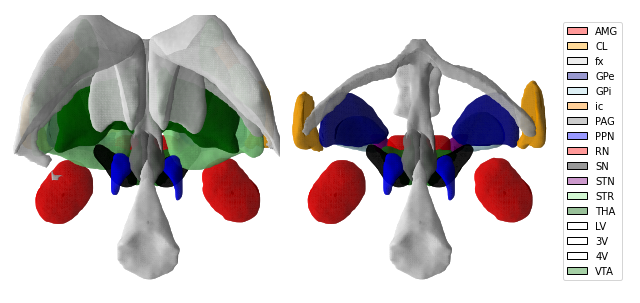

In [46]:
## For orientation
from matplotlib.patches import Patch
draft = False
fig = plt.figure(figsize=(9, 4.5))
gs = matplotlib.gridspec.GridSpec(1, 3, 
                                  figure=fig, left=None, bottom=None, right=None, top=None, 
                                  wspace=0, hspace=0, 
                                  width_ratios=[1,1,.3], 
                                 )

# rear view
azdeg= 90
if not draft:
    all_mpl_meshes, norm = load_mpl_location_meshes(structs['18to30'], alphas=[1,1], azdeg=azdeg)
ax = fig.add_subplot(gs[0,0], projection='3d')
xyz_min, xyz_max = plot_all_meshes_with_arrows([x for x in all_mpl_meshes if x['name'] in ['AMG', 'CL', 'fx', 'GPi', 'GPe',  'ic', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'STR', 'THA', 'VTA', '3V', '4V', 'LV']
                                                # ['GPi', 'GPe', 'CL', 'PAG', 'SN', 'STN', 'RN', 'AMG', 'VTA', 'STR',  '3V', '4V', 'fx', 'LV']
                                                ], 0, azdeg, alpha=1, linewidth=2,
                                                fig=fig, ax=ax, draft=draft, mutation_scale_large=7, mutation_scale_small=2, zoom=1.7)

# remove large structures here (STR, THA, LV)
ax = fig.add_subplot(gs[0,1], projection='3d')
plot_all_meshes_with_arrows([x for x in all_mpl_meshes if x['name'] in ['AMG', 'CL', 'fx', 'GPi', 'GPe',  'PAG', 'PPN', 'RN', 'SN', 'STN', 'VTA', '3V', '4V']], 0, azdeg, alpha=1, linewidth=2,
                            fig=fig, ax=ax, draft=draft, mutation_scale_large=7, mutation_scale_small=2, xyz_min=xyz_min, xyz_max=xyz_max, zoom=1.7)

# legend
legend_elements = [Patch(facecolor=np.append(np.array(matplotlib.colors.to_rgba(y['color']))[:3], 0.4), edgecolor='k', label=x) for x,y in settings.items()]
ax = fig.add_subplot(gs[0,2])
ax.axis('off')
ax.legend(handles=legend_elements, loc='center')

fig.tight_layout()

3V-3... 4V-4... AMG-L... AMG-R... CL-L... CL-R... GPe-L... GPe-R... GPi-L... GPi-R... LV-L... LV-R... PAG-L... PAG-R... PPN-L... PPN-R... RN-L... RN-R... SN-L... SN-R... STN-L... STN-R... STR-L... STR-R... THA-L... THA-R... VTA-L... VTA-R... fx... ic-L... ic-R... 

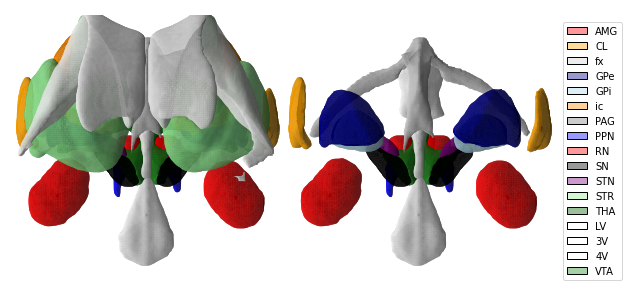

In [47]:
## For orientation
from matplotlib.patches import Patch
draft = False
fig = plt.figure(figsize=(9, 4.5))
gs = matplotlib.gridspec.GridSpec(1, 3, 
                                  figure=fig, left=None, bottom=None, right=None, top=None, 
                                  wspace=0, hspace=0, 
                                  width_ratios=[1,1,.3], 
                                 )

# frontal view
azdeg= 90+180
if not draft:
    all_mpl_meshes, norm = load_mpl_location_meshes(structs['18to30'], alphas=[1,1], azdeg=azdeg)
ax = fig.add_subplot(gs[0,0], projection='3d')
xyz_min, xyz_max = plot_all_meshes_with_arrows([x for x in all_mpl_meshes if x['name'] in ['AMG', 'CL', 'fx', 'GPi', 'GPe',  'ic', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'STR', 'THA', 'VTA', '3V', '4V', 'LV']
                                                # ['GPi', 'GPe', 'CL', 'PAG', 'SN', 'STN', 'RN', 'AMG', 'VTA', 'STR',  '3V', '4V', 'fx', 'LV']
                                                ], 0, azdeg, alpha=1, linewidth=2,
                                                fig=fig, ax=ax, draft=draft, mutation_scale_large=7, mutation_scale_small=2, zoom=1.7)

# remove large structures here (STR, THA, LV)
ax = fig.add_subplot(gs[0,1], projection='3d')
plot_all_meshes_with_arrows([x for x in all_mpl_meshes if x['name'] in ['AMG', 'CL', 'fx', 'GPi', 'GPe',  'PAG', 'PPN', 'RN', 'SN', 'STN', 'VTA', '3V', '4V']], 0, azdeg, alpha=1, linewidth=2,
                            fig=fig, ax=ax, draft=draft, mutation_scale_large=7, mutation_scale_small=2, xyz_min=xyz_min, xyz_max=xyz_max, zoom=1.7)

# legend
legend_elements = [Patch(facecolor=np.append(np.array(matplotlib.colors.to_rgba(y['color']))[:3], 0.4), edgecolor='k', label=x) for x,y in settings.items()]
ax = fig.add_subplot(gs[0,2])
ax.axis('off')
ax.legend(handles=legend_elements, loc='center')

fig.tight_layout()

3V-3... 4V-4... AMG-L... AMG-R... CL-L... CL-R... GPe-L... GPe-R... GPi-L... GPi-R... LV-L... LV-R... PAG-L... PAG-R... PPN-L... PPN-R... RN-L... RN-R... SN-L... SN-R... STN-L... STN-R... STR-L... STR-R... THA-L... THA-R... VTA-L... VTA-R... fx... ic-L... ic-R... 

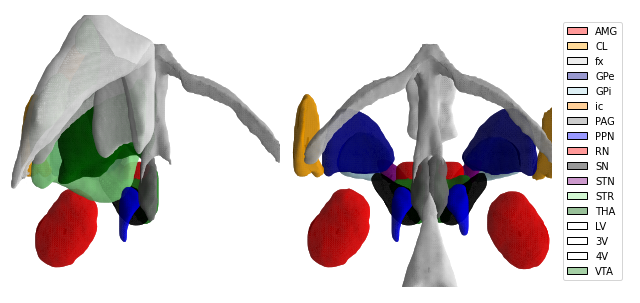

In [57]:
## For orientation
from matplotlib.patches import Patch
draft = False
fig = plt.figure(figsize=(9, 4.5))
gs = matplotlib.gridspec.GridSpec(1, 3, 
                                  figure=fig, left=None, bottom=None, right=None, top=None, 
                                  wspace=0, hspace=0, 
                                  width_ratios=[1,1,.3], 
                                 )

# caudal view
azdeg= 90
if not draft:
    all_mpl_meshes, norm = load_mpl_location_meshes(structs['18to30'], alphas=[1,1], azdeg=azdeg)
ax = fig.add_subplot(gs[0,0], projection='3d')
xyz_min, xyz_max = plot_all_meshes_with_arrows([x for x in all_mpl_meshes if x['name'] in ['AMG', 'CL', 'fx', 'GPi', 'GPe',  'ic', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'STR', 'THA', 'VTA', '3V', '4V', 'LV'] and x['hemisphere'] in ['L', 'lr']
                                                # ['GPi', 'GPe', 'CL', 'PAG', 'SN', 'STN', 'RN', 'AMG', 'VTA', 'STR',  '3V', '4V', 'fx', 'LV']
                                                ], 0, azdeg, alpha=1, linewidth=2,
                                                fig=fig, ax=ax, draft=draft, mutation_scale_large=7, mutation_scale_small=2, zoom=1.7)

# remove large structures here (STR, THA, LV)
ax = fig.add_subplot(gs[0,1], projection='3d')
plot_all_meshes_with_arrows([x for x in all_mpl_meshes if x['name'] in ['AMG', 'CL', 'fx', 'GPi', 'GPe',  'PAG', 'PPN', 'RN', 'SN', 'STN', 'VTA', '3V', '4V']], 0, azdeg, alpha=1, linewidth=2,
                            fig=fig, ax=ax, draft=draft, mutation_scale_large=7, mutation_scale_small=2, xyz_min=xyz_min, xyz_max=xyz_max, zoom=1.7)

# legend
legend_elements = [Patch(facecolor=np.append(np.array(matplotlib.colors.to_rgba(y['color']))[:3], 0.4), edgecolor='k', label=x) for x,y in settings.items()]
ax = fig.add_subplot(gs[0,2])
ax.axis('off')
ax.legend(handles=legend_elements, loc='center')

fig.tight_layout()

# Thickness

### 1. generate meshes for young and old decades

In [24]:
def load_mpl_meshes_thickness(structs, centralize=False, azdeg=0, altdeg=0):
    all_mpl_meshes = []
    
    # First run: just get all random intensities, required for normalizing
#     all_intensities = np.array([])
#     all_ranges = []
#     for decade in ['18to30', '71to80']:
#         for i, (roi_name, mesh_data) in enumerate(structs[decade].items()):
#     #        print(f'{roi_name}... ', end='')

#             if not roi_name == 'fx':
#                 roi_name, hemisphere = roi_name.split('-')
#             else:
#                 roi_name = 'fx'
#                 hemisphere = 'lr'
#             verts = mesh_data['verts']
#             faces = mesh_data['faces']

#             ## 
# #             for age in [19,75]:
# #                 median_intensity = get_prediction(models.loc[(models.qMRI == qMRI) & (models.ROI == roi_name) & (models.Statistic == 'median'), 'result'].iloc[0], age=age)
# #                 iqr_intensity = get_prediction(models.loc[(models.qMRI == qMRI) & (models.ROI == roi_name) & (models.Statistic == 'iqr'), 'result'].iloc[0], age=age)

# #                 random_intensities = truncnorm.rvs(0, 35, loc=median_intensity, scale=iqr_intensity*1.349425*0.9, size=faces.shape[0])
# #                 all_intensities = np.concatenate([all_intensities, random_intensities])

#             # verts
#             all_ranges.append([verts.min(0), verts.max(0)])
    
#     # final ranges
#     xyz_min = np.array(all_ranges).min(0)[0]
#     xyz_max = np.array(all_ranges).max(0)[1]
#     com = xyz_min+(xyz_max-xyz_min)/2
    
#     norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
#     mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)

    # Now actually create meshes
    for roi_name_orig in structs['18to30'].keys():
        print(f'{roi_name_orig}... ', end='')
        
        if not roi_name_orig == 'fx':
            roi_name, hemisphere = roi_name_orig.split('-')
        else:
            roi_name = 'fx'
            hemisphere = 'lr'
        
        # get center of mass of young
        verts = structs['18to30'][roi_name_orig]['verts'].copy()
        xyz_min = verts.min(0)#[0]
        xyz_max = verts.max(0)#[1]
        com = xyz_min+(xyz_max-xyz_min)/2
        
        # get shifted ranges - this is the range to plot for young participants
        if centralize:
            xyz_min = (verts-com).min(0)
            xyz_max = (verts-com).max(0)
        
        for decade in ['18to30', '71to80']:
            verts = structs[decade][roi_name_orig]['verts'].copy()
            faces = structs[decade][roi_name_orig]['faces']
            normals = structs[decade][roi_name_orig]['normals']
        
#         # centralize
            if centralize:
                verts -= com
            # Define lightsource
            ls = LightSource(azdeg=azdeg, altdeg=altdeg)

            # First change - normals are per vertex, so I made it per face.
            normalsarray = np.array([np.array((np.sum(normals[face[:], 0]/3), np.sum(normals[face[:], 1]/3), 
                                               np.sum(normals[face[:], 2]/3))/np.sqrt(np.sum(normals[face[:], 0]/3)**2 + np.sum(normals[face[:], 1]/3)**2 + np.sum(normals[face[:], 2]/3)**2)) for face in faces])

            # Next this is more asthetic, but it prevents the shadows of the image being too dark. (linear interpolation to correct)
            min_ = np.min(ls.shade_normals(normalsarray, fraction=1.0)) # min shade value
            max_ = np.max(ls.shade_normals(normalsarray, fraction=1.0)) # max shade value
            diff = max_-min_
            newMin = 0.3
            newMax = 0.95
            newdiff = newMax-newMin

            # Create Ploy3D and set up a light source
            mesh = Poly3DCollection(verts[faces])

            # Using a constant color, put in desired RGB values here.
            colourRGB = np.array(matplotlib.colors.to_rgba(settings[roi_name]['color']))

            # The correct shading for shadows are now applied. Use the face normals and light orientation to generate a shading value and apply to the RGB colors for each face.
            rgbNew = colourRGB*(newMin + newdiff*((ls.shade_normals(normalsarray, fraction=1.0)[:,np.newaxis]-min_)/diff))

            # Apply color to face
            if decade == '18to30':
                young_mesh = deepcopy(mesh)
                young_mesh.set_facecolor(rgbNew)
#                 young_mesh.set_alpha(alphas[0])
            elif decade == '71to80':
                
                if centralize:
                    # determine plotting (x,y,z)limits of the elderly: We want the _ranges_ to be the same as the young, but centered on the COM of the elderly mesh
                    xyz_min_old = verts.min(0)#[0]
                    xyz_max_old = verts.max(0)#[1]
                    com = xyz_min_old+(xyz_max_old-xyz_min_old)/2 # should be approximately 0,0,0

                    ranges_old = [com+xyz_min, com+xyz_max]
                else:
                    ranges_old = [xyz_min, xyz_max]
            
                old_mesh = deepcopy(mesh)
                old_mesh.set_facecolor(rgbNew)
#                 old_mesh.set_alpha(alphas[1])

        all_mpl_meshes.append({'mesh':deepcopy(young_mesh),  # mesh at 19 yo
                               'old_mesh':deepcopy(old_mesh),  # mesh at 75 yo
                               'ranges': [xyz_min, xyz_max], #[verts.min(0), verts.max(0)], 
                               'ranges_old': ranges_old,
                               'name': roi_name, 
                               'hemisphere': hemisphere,
#                                'com': com, # center of mass at 19 yo
#                                'shifts': [x_shift, y_shift, z_shift], # shift in com between 19-75 yo
                               'color': 'grey'})
    
#        all_mpl_meshes.append({'mesh':deepcopy(mesh), 'old_mesh':deepcopy(old_mesh), 'ranges': [verts.min(0), verts.max(0)], 'name': roi_name, 'hemisphere': hemisphere})
    return all_mpl_meshes

In [25]:
# pd.DataFrame(all_mpl_meshes).set_index('name').reindex([]).reset_index()

In [26]:
def plot_timespans_with_meshes_thickness(all_mpl_meshes, df, qMRI, total_changes_table, draft=False):
    # Plot a draft? if True, don't plot meshes
    # draft = False

    meshes_df = pd.DataFrame(all_mpl_meshes)
#    meshes_to_plot = meshes_df.loc[(~meshes_df.name.isin(['4V']))&(meshes_df.hemisphere.isin(['L', 'lr', '3', '4']))]
    meshes_to_plot = meshes_df.loc[(meshes_df.hemisphere.isin(['L', 'lr', '3', '4']))]
#     meshes_to_plot['name_lowercase'] = meshes_to_plot['name'].copy().apply(lambda x: x.lower()).replace({'lv': 'v1', '3v': 'v3', '4v': 'v4'})
#     meshes_to_plot = meshes_to_plot.sort_values('name_lowercase')
    # sorting:
    sorting = ['LV', '3V', '4V',   #
               'STR', 'THA', 'ic', 
               'fx', 'AMG', 'CL', 
               'GPe', 'GPi', 'SN', 
               'VTA', 'PAG', 'PPN', 
               'RN', 'STN']
    vol_ylim = [[5e2, 1e5],
                 [1e3, 3e4],
                 [5e2, 1e4],
                 [1e2, 5e3],
                 [1e2, 1e3],
                 [1e2, 1e3]
                 ]
    vol_yticks = [[1e3, 1e4, 1e5],
                 [1e3, 1e4],
                 [1e3, 1e4],
                 [1e2, 1e3],
                 [1e2, 1e3],
                 [5e1, 1e2, 1e3]
                 ]
    
    thick_ylim = [[0, 10],
                  [2, 10],
                  [0.5, 7.5],
                  [.5, 5],
                  [.5, 3],
                  [0, 7.5]]
    thick_yticks = [[0, 5, 10],
                    [2.5, 5, 7.5, 10],
                    [2.5, 5, 7.5],
                    [2.5, 5, 7.5],
                    [1, 2, 3],
                    [2.5, 5, 7.5]]

    
    meshes_to_plot = meshes_to_plot.set_index('name').reindex(sorting).reset_index()

    # Plot all, see if young -> old changes can be seen
    xwidth_cm = 30 ## this is way too wide for a4 but does give a nice figure when resized. 16 x 16 cm should fit on A4 (keeping margins in mind)
    fig = plt.figure(figsize=(xwidth_cm/2.54, xwidth_cm/2.54*1.4))
    gs = matplotlib.gridspec.GridSpec(6*3, # row for meshes, row for scatters, row empty 
                                      3*4, # THREE cols for meshes/scatters, one col empty 
                                      figure=fig, left=None, bottom=None, right=None, top=None, wspace=0, hspace=0, 
                                      width_ratios=[1,1,1,0.2] * 3, 
                                      height_ratios=[.85,1,0.1] * 6)

    intensity = qMRI
    scatter_ylim = [0,5] # [df.loc[(df['Intensity'] == intensity),'Value'].min(),df.loc[(df['Intensity'] == intensity),'Value'].max()]
    for i,(idx,row_data) in enumerate(meshes_to_plot.iterrows()):
        col = (i%3) * 4  # 3 cols per 'subplot' (one per mesh) + one empty makes 4 cols total per subplot, and we want 3 "grid cols"
        row = np.floor(i/3).astype(int) * 3  # Two rows per subplot (mesh/scatter) + one empty (=3 rows per 'grid row').
        
        # Meshes
        gs00 = gs[row, (col):(col+3)].subgridspec(1, 4, width_ratios=[0.3, 1, 1, 0.3], wspace=0, hspace=0)
        for ii, mesh_type in enumerate(['young_left', 'old_right']):
            if ii == 1:
                mesh = row_data['old_mesh']  # old, right
            else:
                mesh = row_data['mesh']     # young, left
            ranges = row_data['ranges']

#             ax = fig.add_subplot(gs[row, col+ii], projection='3d')
            ax = fig.add_subplot(gs00[0,ii+1], projection='3d')
            if not draft:
                ax.add_collection3d(deepcopy(mesh))
            ax.set_xlim([ranges[0][0], ranges[1][0]])
            ax.set_ylim([ranges[0][1], ranges[1][1]])
            ax.set_zlim([ranges[0][2], ranges[1][2]])
            if not draft:
                ax.axis('off')
            ax.set_box_aspect(aspect=(1,1,1),zoom=1.2)
    #         if ii == 1:
    #             ax.view_init(20, 180)
    #         else:
            ax.view_init(30, 30)
            if ii == 0:
                print('.', end='')
#                 print('{}: ax.azim {}, ax.elev {}'.format(row_data['name'] + '-' + row_data['hemisphere'], ax.azim, ax.elev))
                ax.set_title('23y', loc='left', y=.1, fontdict={'fontsize': 10}, bbox=dict(facecolor='white', alpha=0.75, edgecolor='white', pad=1))
            else:
                ax.set_title('73y', loc='right', y=.1, fontdict={'fontsize': 10}, bbox=dict(facecolor='white', alpha=0.75, edgecolor='white', pad=1))

        ax = fig.add_subplot(gs[slice(row, row+3), slice(col, col+3)])
        roi_name = row_data['name']
        if roi_name in ['fx', 'ic']:
            roi_name = '$\it{' + roi_name + '}$'
        ax.set_title(roi_name, y=.9)
        ax.axis('off')

        # scatterplots
        gs10 = gs[row+1, (col):(col+3)].subgridspec(1, 4, width_ratios=[1, 1, .1, 1], wspace=0, hspace=0) # new gridspec
        for ii, statistic in enumerate(['median', 'iqr', 'volume']):
#            ax = fig.add_subplot(gs[row+1,col+ii])
            ax = fig.add_subplot(gs10[0,ii+int(statistic=='volume')])
            data_ = df.loc[(df['ROI']==row_data['name']) & (df['Intensity'].isin(['thickness', 'volume'])) & (df['Statistic'] == statistic)]
            ax.grid(linestyle='--', color='lightgrey')
            ax.scatter(data_.Age, data_.Value, s=1, color=colors[0])
            
            ax.spines['top'].set_visible(False)
            if statistic in ['median', 'iqr']:
#                ax.set_ylim(scatter_ylim)
#                ax.set_yticks([0,5,10])
                ax.set_ylim(thick_ylim[int(row/3)])
                ax.set_yticks(thick_yticks[int(row/3)])

                ax.spines['right'].set_visible(False)
                if col > 0 or ii == 1:
                    ax.set_yticklabels([])
            else:
                ax.set_yscale('log')
                ax.yaxis.tick_right()
                ax.yaxis.set_label_position("right")
                ax.get_yaxis().set_minor_formatter(matplotlib.ticker.LogFormatter(labelOnlyBase=True))  # only base labels
                ax.spines['left'].set_color('grey')

                ax.set_ylim(vol_ylim[int(row/3)])
                ax.set_yticks(vol_yticks[int(row/3)])
                if col < 8 and not (int(row/3) == 5):
                    ax.set_yticklabels([])
                if (row/3) == 5 and col == 0:
                    ax.set_yticklabels([])
                
            if row/3 < 5:
                ax.set_xticklabels([])

            # model
            result_ = models.loc[(models.ROI == row_data['name']) & (models.qMRI.isin(['thickness', 'volume'])) & (models.Statistic == statistic), 'result'].iloc[0]
            pred1 = result_.predict(pred_dfM)
            pred2 = result_.predict(pred_dfF)
            if (pred1 == pred2).all():
                ax.plot(np.arange(19,81), pred1, 'k')
            else:
                ax.plot(np.arange(19,81), pred1, 'red')
                ax.plot(np.arange(19,81), pred2, 'green')
            title_text = ' Med.' if statistic == 'median' else ' IQR' if statistic == 'iqr' else ' Vol.'
            
            if statistic == 'volume':
                if data_.Value.mean() > np.mean(vol_ylim[int(row/3)]):
                    title_y_pos = 0.05
                else:
                    title_y_pos = 0.8
                total_change = total_changes_table.loc[row_data['name'], ('volume', statistic)]
                sign = '+' if total_change > 0 else ''
                title_text += ': ' + sign + str(total_change.round(2)) + '%'
            else:
                if data_.Value.mean() > 5:
                    title_y_pos = 0.05
                else:
                    title_y_pos = 0.8
                total_change = total_changes_table.loc[row_data['name'], (qMRI, statistic)]
                sign = '+' if total_change > 0 else ''
                if np.abs(total_change) > 10:
                    total_change = int(total_change.round(0))
                else:
                    total_change = total_change.round(2)
                title_text += ': ' + sign + str(total_change) + '%'

            ax.set_title(title_text, y=title_y_pos, loc='left', fontdict={'fontsize': 10})

    fig.text(0.5, 0.1, 'Age', ha='center')
    fig.text(0.08, 0.5, '{} (mm)'.format(qMRI.capitalize()), va='center', rotation='vertical')
    fig.text(0.92, 0.5, 'Volume (mm$^3$)', va='center', rotation='vertical')

    return fig

In [29]:
thickness_mpl_meshes = load_mpl_meshes_thickness(structs, centralize=False, azdeg=30, altdeg=45)
# # fig = plot_timespans_with_meshes_thickness(all_mpl_meshes=thickness_mpl_meshes, df=df, qMRI='thickness', total_changes_table=final_table_absolute, draft=True)

3V-3... 4V-4... AMG-L... AMG-R... CL-L... CL-R... GPe-L... GPe-R... GPi-L... GPi-R... LV-L... LV-R... PAG-L... PAG-R... PPN-L... PPN-R... RN-L... RN-R... SN-L... SN-R... STN-L... STN-R... STR-L... STR-R... THA-L... THA-R... VTA-L... VTA-R... fx... ic-L... ic-R... 

In [30]:
final_table_relative = pd.read_pickle('../data/interim_data/summary_table_qmri_proportional.pkl')*100  # to percentage

.................

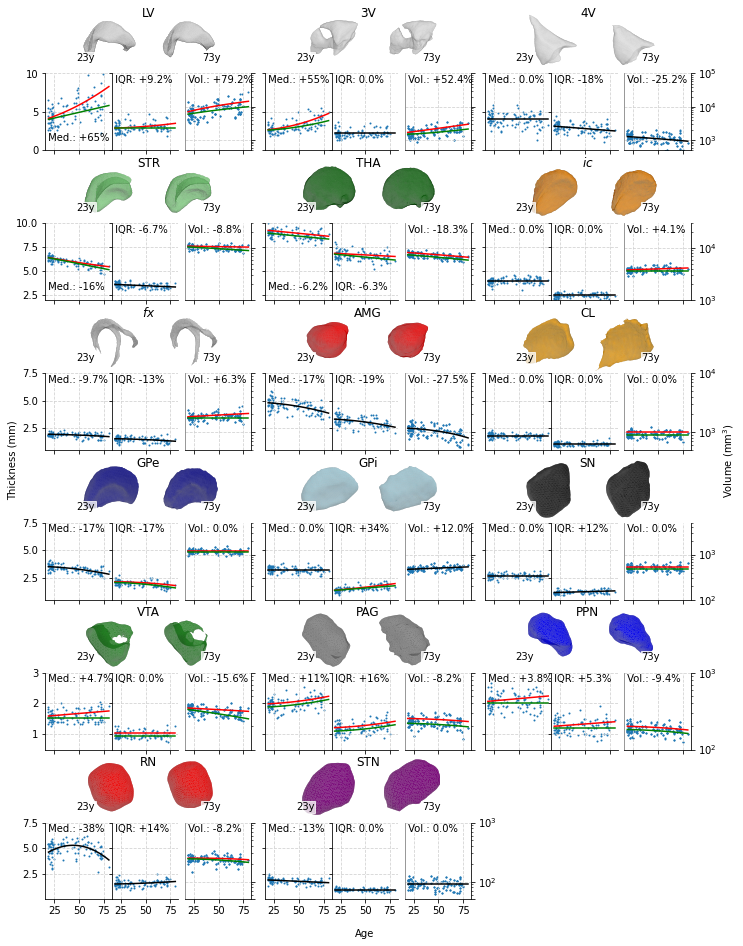

In [31]:
fig = plot_timespans_with_meshes_thickness(all_mpl_meshes=thickness_mpl_meshes, df=df, qMRI='thickness', total_changes_table=final_table_relative, draft=False)
fig.savefig('../figures/aging_thickness_massp2-newmesh_r1_2.jpeg', dpi=250, bbox_inches='tight')

.................

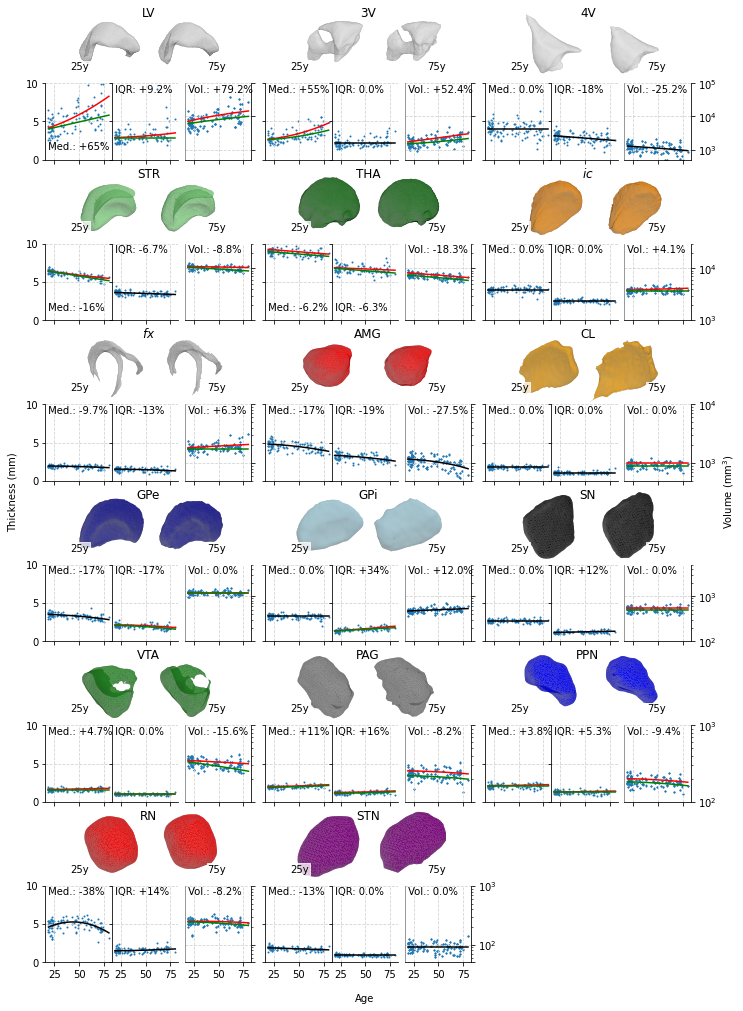

In [17]:
fig = plot_timespans_with_meshes_thickness(all_mpl_meshes=thickness_mpl_meshes, df=df, qMRI='thickness', total_changes_table=final_table_relative, draft=False)

In [21]:
fig = plot_timespans_with_meshes_thickness(all_mpl_meshes=thickness_mpl_meshes, df=df, qMRI='thickness', total_changes_table=final_table_relative, draft=False)

NameError: name 'thickness_mpl_meshes' is not defined

In [18]:
fig.savefig('../figures/aging_thickness_massp2-newmesh.jpeg', dpi=250, bbox_inches='tight')
# fig.savefig('thickness_change_newmeshes.pdf', bbox_inches='tight')

3V-3... 4V-4... AMG-L... AMG-R... CL-L... CL-R... GPe-L... GPe-R... GPi-L... GPi-R... LV-L... LV-R... PAG-L... PAG-R... PPN-L... PPN-R... RN-L... RN-R... SN-L... SN-R... STN-L... STN-R... STR-L... STR-R... THA-L... THA-R... VTA-L... VTA-R... fx... ic-L... ic-R... 

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

................

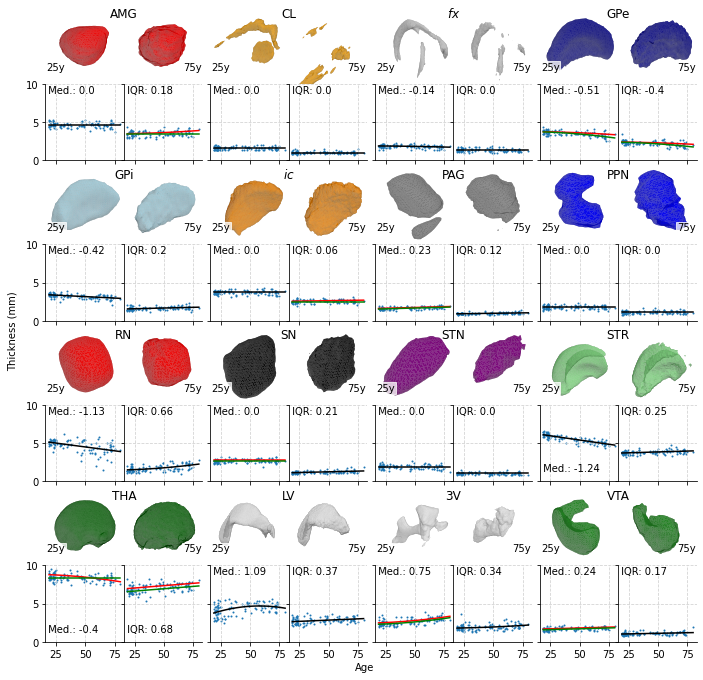

In [75]:
test = load_mpl_meshes_thickness(structs, centralize=True, azdeg=30, altdeg=45)
fig = plot_timespans_with_meshes_thickness(all_mpl_meshes=test, df=df, qMRI='thickness', total_changes_table=final_table_absolute, draft=False)

In [76]:
fig.savefig('thickness_change.jpeg', dpi=250, bbox_inches='tight')
fig.savefig('thickness_change.pdf', bbox_inches='tight')

In [61]:
structure_name = 'STN-L'
print((structs['18to30'][structure_name]['verts'].max(0)-structs['18to30'][structure_name]['verts'].min(0))*25)
print((structs['71to80'][structure_name]['verts'].max(0)-structs['71to80'][structure_name]['verts'].min(0))*25)

[ 37.55444717 111.60182953  38.52574158]
[32.72013855 87.46944427 32.27151489]


In [60]:
structure_name = 'STN-R'
print((structs['18to30'][structure_name]['verts'].max(0)-structs['18to30'][structure_name]['verts'].min(0))*25)
print((structs['71to80'][structure_name]['verts'].max(0)-structs['71to80'][structure_name]['verts'].min(0))*25)

[9.14495087 8.34857941 6.25299835]
[8.07346344 7.32744598 6.78025436]


In [45]:
stn_l_left = [x for x in test if x['name'] == 'STN'][0]

TypeError: list indices must be integers or slices, not dict

In [46]:
idx

{'mesh': <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fdaba296850>,
 'old_mesh': <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fda82d182d0>,
 'ranges': [array([3.2752417 , 4.32114838, 2.47317307]),
  array([3.58988708, 4.60824371, 2.68247589])],
 'name': 'STN',
 'hemisphere': 'L',
 'color': 'grey'}

In [774]:
# regex = re.compile(f'.*ahead-qmri2_avg-(?P<roi>\S+)_hem-(?P<hemisphere>\S+)_decade-{decade}_n*')
# all_meshes_data = {}

# for fn in all_masks_fns:
#     #
#     roi_name = regex.match(fn).groupdict()['roi']
#     hemisphere = regex.match(fn).groupdict()['hemisphere']
#     mask_name = regex.match(fn).groupdict()['roi'] + regex.match(fn).groupdict()['hemisphere']
    
#     if roi_name == 'gpe':
#         roi_name = 'GPe'
#     elif roi_name == 'gpi':
#         roi_name = 'GPi'
#     elif mask_name == 'vent3':
#         roi_name = '3V'
#     elif mask_name == 'vent4':
#         roi_name = '4V'
#     elif mask_name == 'ventr' or mask_name == 'ventl':
#         roi_name = 'LV'
#     elif roi_name == 'fx':
#         roi_name = 'fx'
#     elif roi_name == 'ic':
#         roi_name = 'ic'
#     else:
#         roi_name = roi_name.upper()
#     print(f'{roi_name}... ', end='')

#     # data
#     raw_data = nib.load(fn).get_fdata()
    
#     marchCubeSpace = 1.0 / 50.0
#     verts, faces, normals, values = measure.marching_cubes(raw_data, 0.5, spacing=(marchCubeSpace, marchCubeSpace, marchCubeSpace))
#     all_meshes_data[roi_name + '-' + hemisphere] = {'verts': verts, 'faces': faces, 'normals': normals, 'values': values}
    
#     save_fn = f'./objs/decade-{decade}/{roi_name}-{hemisphere}.obj'
#     if not os.path.exists(os.path.dirname(save_fn)):
#         os.makedirs(os.path.dirname(save_fn))
#     write_obj(save_fn, verts, faces, normals)

AMG... AMG... CL... CL... fx... GPe... GPe... GPi... GPi... ic... ic... PAG... PAG... PPN... PPN... RN... RN... SN... SN... STN... STN... STR... STR... THA... THA... 3V... 4V... LV... LV... VTA... VTA... 

In [773]:
fn

'/home/pilou/Projects/Ahead-Database/Automated-Parcellation/atlas_maps/qmri2/ahead-qmri2_avg-amg_hem-l_decade-18to30_n42.nii.gz'